##24 Hour Advanced Solar Power Forecasting

The goal of this project is to predict solar power output 24 hours ahead of time when given 12 weather variables obtained from the European Centre for Medium-range Weather Forecasts.

Root mean squared error and mean absolute error are used to calculate the accuracy of the predictions. 

View Summary Statistics?
1: Yes 2: No
2
View Correlation Heat Map?
1: Yes 2: No
1


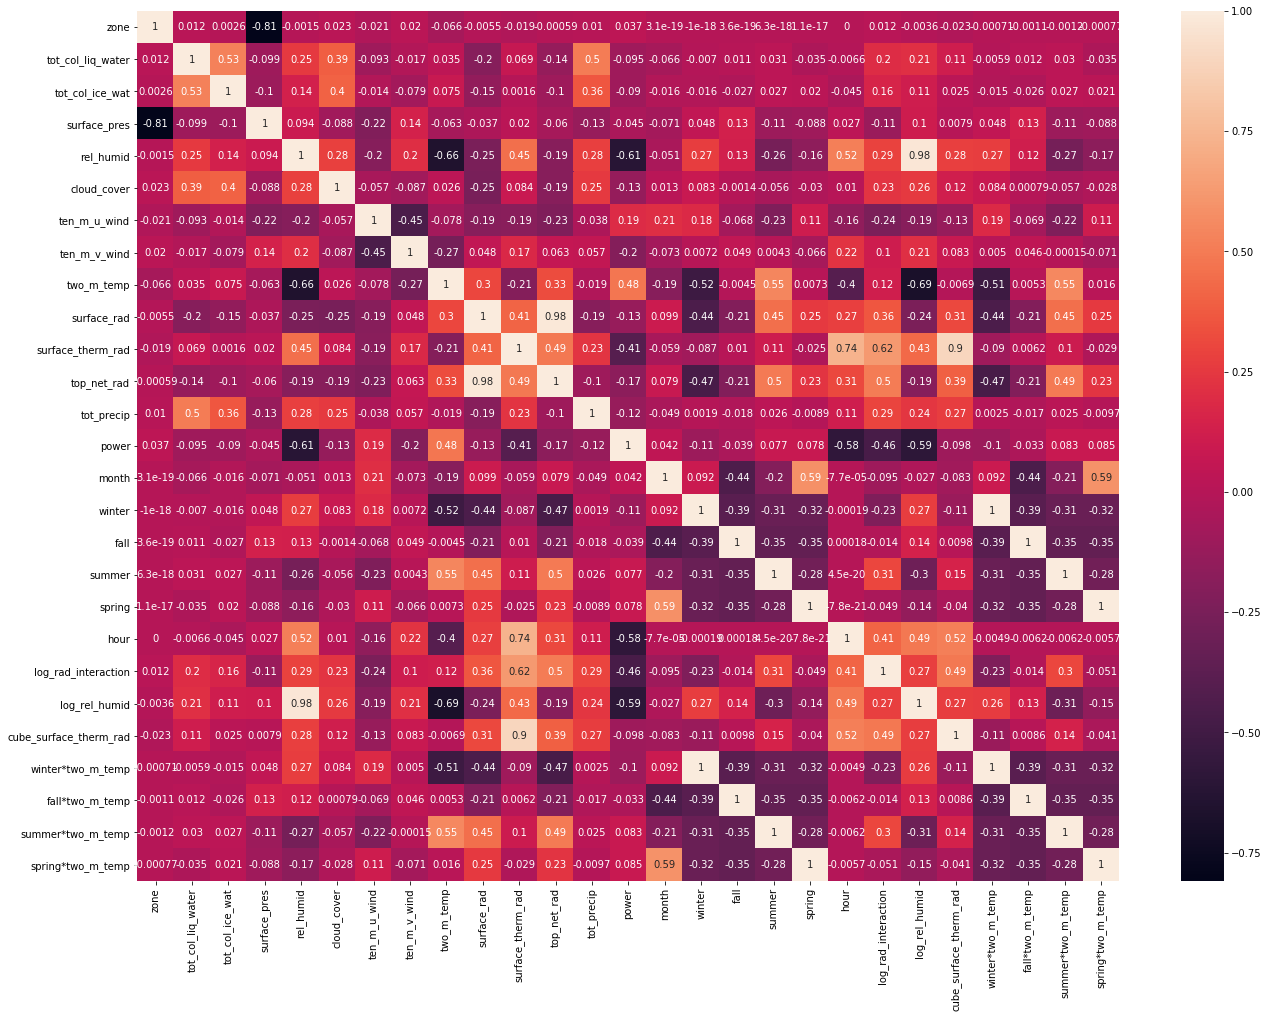

View Feature Importance Using Gradient Boosting Regression?
1: Yes 2: No
1
GBRT RMSE: 0.13024137755468176


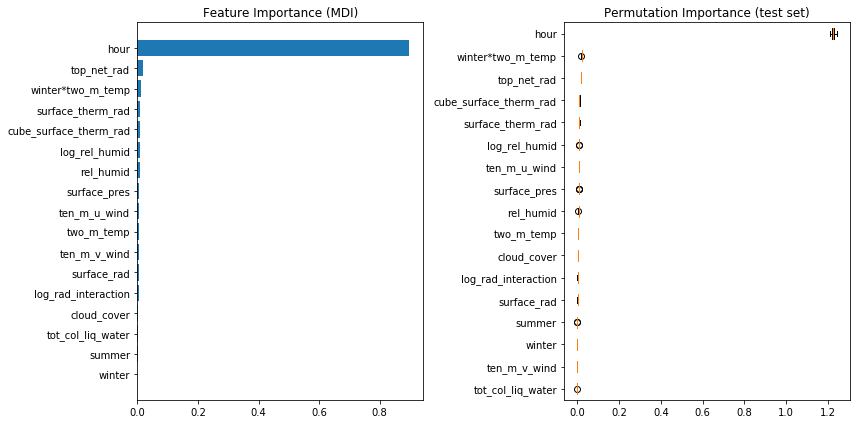

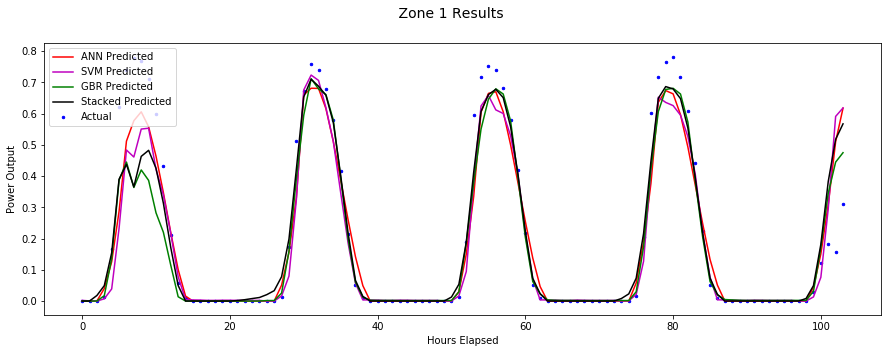

Zone 1 Results
Model      support_vector  nueral_network  gradient_boost  stacked_regressor
R-Squared        0.811094        0.807736        0.799949           0.820384
RMSE             0.112446        0.113441        0.115716           0.109646
MAE              0.059813        0.056390        0.061552           0.057870



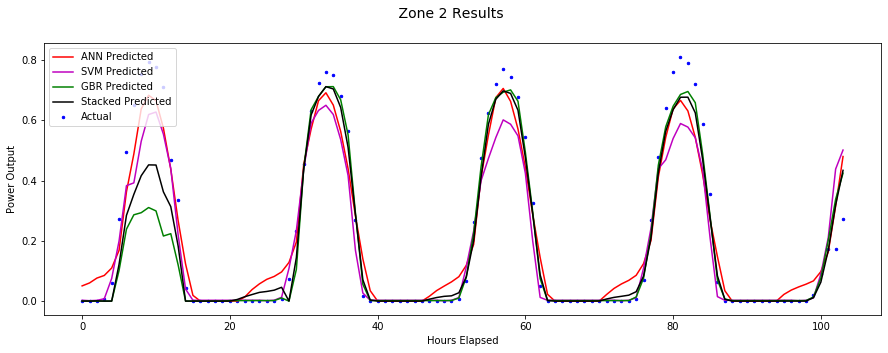

Zone 2 Results
Model      support_vector  nueral_network  gradient_boost  stacked_regressor
R-Squared        0.804798        0.804562        0.783988           0.811324
RMSE             0.121780        0.121854        0.128107           0.119727
MAE              0.075141        0.066875        0.068773           0.066059



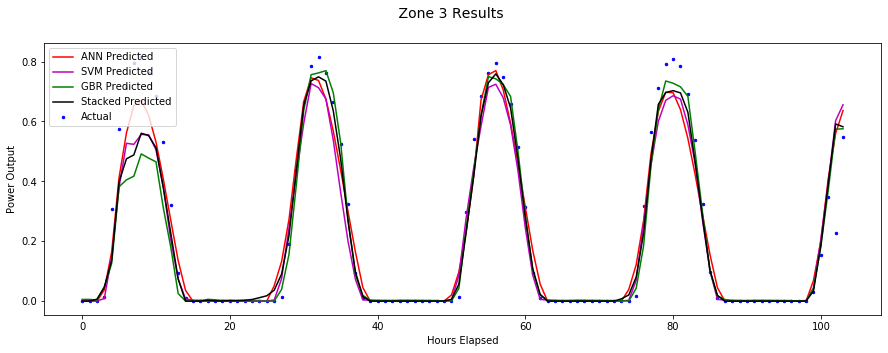

Zone 3 Results
Model      support_vector  nueral_network  gradient_boost  stacked_regressor
R-Squared        0.811670        0.815707        0.809993           0.823252
RMSE             0.120696        0.119396        0.121232           0.116926
MAE              0.064858        0.063867        0.067210           0.062930



In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import datetime as dt
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
import json, os, csv, warnings
warnings.filterwarnings("ignore")


#function to extract and transform data
def get_data(*argv,**kwargs):    
    #reads the csv file containing the dimensions and target variable into a dataframe
    data = pd.read_csv('solar.csv')
    #sets the column names of the dataframe
    data.columns = ['zone','timestamp','tot_col_liq_water','tot_col_ice_wat','surface_pres','rel_humid','cloud_cover','ten_m_u_wind','ten_m_v_wind','two_m_temp','surface_rad','surface_therm_rad','top_net_rad','tot_precip','power']
    #sets the timestamp column to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    #adds categorical columns
    data['month'],data['winter'],data['fall'],data['summer'],data['spring'],data['hour']=[data['timestamp'].dt.month,0,0,0,0,data['timestamp'].dt.hour]
    data.loc[data['month'].isin([9,10,11]),'spring'], data.loc[data['month'].isin([12,1,2]),'summer'],data.loc[data['month'].isin([3,4,5]),'fall'],data.loc[data['month'].isin([6,7,8]),'winter'] = [1,1,1,1]    
    #creates features based off of visual inspection and feature selection function
    #****FEATURE CREATION****
    data['log_rad_interaction'] = np.log(data['top_net_rad'] - data['surface_rad'])
    data['log_rel_humid'] = np.log(data['rel_humid'])
    data['cube_surface_therm_rad'] = data['surface_therm_rad']*data['surface_therm_rad']*data['surface_therm_rad']
    data['winter*two_m_temp'] = data['winter']*data['two_m_temp']
    data['fall*two_m_temp'] = data['fall']*data['two_m_temp']
    data['summer*two_m_temp'] = data['summer']*data['two_m_temp']
    data['spring*two_m_temp'] = data['spring']*data['two_m_temp']
    data=data.fillna(0)
    #splits the data by the project requried datetime    
    train,test=[data[data['timestamp']< dt(2013,7,1,0,0)],data[data['timestamp']>= dt(2013,7,1,0,0)]]   
    #splits the data by zone and training vs test data
    test=[test[test['zone']==1].reset_index(drop=True),test[test['zone']==2].reset_index(drop=True),test[test['zone']==3].reset_index(drop=True)]
    train=[train[train['zone']==1].reset_index(drop=True),train[train['zone']==2].reset_index(drop=True),train[train['zone']==3].reset_index(drop=True)]
    x = 0
    #shifts the power column up 24 positions to set the target variable to 24 hours ahead for 24 hour forecasting purposes
    for x in range(0,3):        
        test[x]['power_forecast'] =  test[x].sort_values(by=['timestamp']).power.shift(-24)
        test[x].replace('',np.nan,inplace=True) 
        test[x].dropna(subset = ['power_forecast'], inplace=True)
        test[x].reset_index(drop=True)
        train[x]['power_forecast'] = train[x].sort_values(by=['timestamp']).power.shift(-24)
        train[x].replace('',np.nan,inplace=True) 
        train[x].dropna(subset = ['power_forecast'], inplace=True)  
        train[x].reset_index(drop=True)    
    #calls function to present user with options to analyze the given dataset
    dimension_analysis(data,pd.concat(train),pd.concat(test),argv[0])    
    #returns the data in a dictionary
    output={'test':test,'train':train}       
    return output
    
def dimension_analysis(data,train,test,*argv,**kwargs):
    print('View Summary Statistics?')
    print('1: Yes 2: No')
    run = input()
    if run == "1":
        print(data.describe())
    
    print('View Correlation Heat Map?')
    print('1: Yes 2: No')
    run = input()
    if run == "1":
        correlation(data)     
        
    print('View Feature Importance Using Gradient Boosting Regression?')
    print('1: Yes 2: No')
    run = input()
    if run == "1":
        GBR_feature_selection(train,test,argv[0])   
        
#used to show a correlation table in heatmap format 
def correlation(data):
    corr=data.corr()
    fig = plt.figure(figsize=(22,16))
    sn.heatmap(corr, annot=True)
    plt.show()
    plt.close('all') 

#uses GradientBoostingRegressor to indicate feature importance and plots feature importance     
def GBR_feature_selection(train,test,*argv,**kwargs):
    data = power_forecast_data(train,test)
    params = argv[0]['gradient_boost']['best_parameters']    
    gbr = argv[0]['gradient_boost']['model'].set_params(**params)
    gbr.fit(data['X_train'], data['Y_train'])
    print('GBRT RMSE: ' + str(sqrt(mse(data['Y_test'], gbr.predict(data['X_test'])))))
    sorted_idx = np.argsort(gbr.feature_importances_)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, gbr.feature_importances_[sorted_idx], align='center')
    plt.yticks(pos, np.array(data['X_train'].columns)[sorted_idx])
    plt.title('Feature Importance (MDI)')
    result = permutation_importance(gbr, data['X_test'], data['Y_test'], n_repeats=10,random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(result.importances[sorted_idx].T,vert=False, labels=np.array(data['X_train'].columns)[sorted_idx])
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()
    plt.close('all')  

#used to normalize and manipulate the data
def normalize(data):
    #used to indicate columns of unwanted data to test model performance with different features
    drop_columns= ['fall','spring','tot_precip','tot_col_ice_wat','fall*two_m_temp','summer*two_m_temp','spring*two_m_temp']
    #used to indicate categorical columns
    categorical = ['winter','fall','summer','spring','hour']
    #used to indicated non_categorical columns #'int_winter_two_m_temp',
    non_categorical = ['log_rad_interaction','log_rel_humid','cube_surface_therm_rad','winter*two_m_temp','fall*two_m_temp','summer*two_m_temp','spring*two_m_temp','tot_col_liq_water','tot_col_ice_wat','surface_pres','rel_humid','cloud_cover','ten_m_u_wind','ten_m_v_wind','two_m_temp','surface_rad','surface_therm_rad','top_net_rad','tot_precip']        
    #normalizes non-categorical data
    X_data_non_categorical = pd.DataFrame(StandardScaler().fit_transform(data[non_categorical]),columns=non_categorical)
    #creates categrical data dataframe
    X_data_categorical = data[categorical]
    #combines categorical and non-categorical dataframes into one dataframe for export 
    X_data = pd.concat([X_data_categorical,X_data_non_categorical],axis=1)
    X_data.drop(drop_columns, axis=1,inplace=True)

    return X_data

#splits the given zone data into X and Y training and test data.    
def power_forecast_data(train,test):    
    train=train.reset_index(drop=True)
    test=test.reset_index(drop=True)
    #set the target variable
    target = 'power_forecast'
    #splits the data into X and Y test and training data
    X_train = normalize(train)
    Y_train = train[target]
    X_test = normalize(test)
    Y_test = test[target]
    #returns data as a dictionary   
    output= {'X_train':X_train,'Y_train':Y_train,'X_test': X_test,'Y_test': Y_test}
    return output

#function to return the RMSE of the model
def RMSE(actual,predict):
    output = sqrt(mse(actual, predict))   
    return output

#function to return the MAE of the model
def MAE(y_true,y_pred):    
     output = mae(y_true,y_pred)
     return output
     
#using the training data input the GridSearchCV function tests every combination of the given parameters 
def grid_search(X_train, Y_train,X_test, model, parameters, name):
    #creates a custom scorer to be passed to the GridSearchCV function parameters
    scorer = make_scorer(RMSE, greater_is_better=False)
    grid=GridSearchCV(estimator=model,cv=2,param_grid=parameters,scoring=scorer)
    grid.fit(X_train,Y_train)
    #compiles the results into individual variables 
    best_estimator=grid.best_estimator_
    y_predict = grid.predict(X_test)
    #packages the best parameters and the RMSE of the model into a dictionary to be returned
    export = {'params':grid.best_params_,'best_score':grid.best_score_,'model':best_estimator,'y_predict':y_predict}
    return export
    
#fits each model, produces predicted values, and returns the results of each model as a dictionary
def runModels(models,data,gridsearch):
    results = []
    fit_models = []
    #normalizes the data
    data = power_forecast_data(data[0],data[1])
    #loops through each model and fits the model with the given parameters
    for key, value in models.items():
        #checks which parameters to use (gridsearch method to find the best parameters or the predetermined parameters) and then fits the model 
        if gridsearch == False:
            params = value['best_parameters']
            model = value['model'].set_params(**params)
            model = model.fit(data['X_train'], data['Y_train'])            
        else:
            params = value['gs_parameters']
            #fits the model and/or determines the best parameters.
            grid_result = grid_search(data['X_train'], data['Y_train'], data['X_test'], value['model'], params, key)
            model = grid_result['model']              
        #predicts the value of the target variable using the fitted model
        y_predict = [0 if i < 0 else i for i in model.predict(data['X_test']) ] #model.predict(data['X_test'])#
        #returns R-Squared, Root Mean Squared Error and the Mean Absolute Error for the given model
        r_squared = r2_score(data['Y_test'],y_predict)
        rmse = RMSE(data['Y_test'],y_predict)
        mmae = MAE(data['Y_test'],y_predict)                
        #adds the fitted model to a list to later be passed to the stacked regressor
        fit_models.append((key,model))
        #adds the results of the model to a list
        results.append({'Model':key,'R-Squared':r_squared,'RMSE':rmse,'MAE':mmae,'Predicted':y_predict}) 
    #passes the fitted models to the stacked regressor and then fits the stacked regressor model           
    stacked_model = ensemble.StackingRegressor(estimators=fit_models, passthrough=True)
    stacked_model = stacked_model.fit(data['X_train'], data['Y_train']) 
    #predicts the value of the target variable using the fitted model
    y_predict = [0 if i < 0 else i for i in stacked_model.predict(data['X_test'])]
     #returns R-Squared, Root Mean Squared Error and the Mean Absolute Error for the given model
    r_squared = r2_score(data['Y_test'],y_predict)
    rmse = RMSE(data['Y_test'],y_predict)
    mmae = MAE(data['Y_test'],y_predict)
    #adds the fitted model to a list to later be passed to the stacked regressor
    fit_models.append(stacked_model)
    #adds the results of the model to a list
    results.append({'Model':'stacked_regressor','R-Squared':r_squared,'RMSE':rmse,'MAE':mmae,'Predicted':y_predict} )
    return results

#gets data from csv file, adds created features, and splits data by train vs test data for each zone
data = get_data(models)
#splits the data into test vs. train data
train = data['train']
test = data['test']

z=0
final = []
#loops through each zone, fits each model to the given zone data, and presents the results    
while z <3:
    #combines training and test data for the given zone to be passed to the runModels function
    data = [train[z],test[z]]   
    #passes the data and models to the runModel function for the models to be fitted and ran   
    results = runModels(models,data,False)
    #plots the results of the models vs the actual values
    Y_test = data[1]['power_forecast']       
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(str(str(' Zone '+str(z+1)+' Results')), fontsize=14)
    x_real = np.arange(0,len(Y_test[1458:1562]))
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_real,Y_test[1458:1562], s=6, c='b', marker="o", label='Actual')
    color = ['r','m','g','k']
    label = ['ANN Predicted','SVM Predicted','GBR Predicted','Stacked Predicted']
    for index, item in enumerate(results):        
        y_predict = item['Predicted']                      
        ax1.plot(x_real, y_predict[1458:1562],  c=color[index], label=label[index])
    ax1.legend(loc='upper left') 
    plt.xlabel('Hours Elapsed',fontsize=10)
    plt.ylabel('Power Output',fontsize=10)
    plt.show() 
    plt.close('all')
    z=z+1
    
    #displays the results of each model for the given zone in dataframe format
    df = pd.DataFrame(results)
    df.drop('Predicted', axis=1, inplace=True)    
    df.set_index('Model',inplace=True)    
    df = df.transpose()
    print('Zone '+str(z)+' Results')
    print(df)
    print('')
    stacked=df.pop('stacked_regressor')
    final.append(stacked)
    
#stores dictionary of the models and the model hyperparameters    
models ={
        "support_vector":
            {"model": SVR(),
             "gs_parameters": { 
                                "max_iter" : [20000],
                                "gamma":["scale"],
                                "C" : np.linspace(start=1,stop=10,num=20,endpoint=True),
                                "kernel" : ['rbf'],
                                "degree" : [1,3,5],   
                                "shrinking" : [False],          
                                #break_ties : [True,False]
                                "tol" : [0.0001],  
                                "verbose" : [True]
                                },
             "best_parameters": {
                                "C": 0.9473684736842105,
                                "degree": 1,
                                "gamma": "scale",
                                "kernel": "rbf",
                                "max_iter": 30000,
                                "shrinking": False,
                                "tol": 0.0001,
                                "verbose": False
                                }
            },
            
        "nueral_network":
            {"model": MLPRegressor(),
             "gs_parameters": {
                                "max_iter" : [250],
                                "n_iter_no_change" : [50],
                                "hidden_layer_sizes":[6,6,12,12,12,12,12,12,12,12,12,12],
                                "activation" : ['relu'],
                                "alpha" : [.001,.001,.01],
                                "learning_rate":['adaptive'],
                                "learning_rate_init":[.01],
                                "warm_start":[True],
                                "momentum": [.9],
                                "tol":[.00002],
                                "nesterovs_momentum":[True,False],
                                "verbose" : [True] 
                                },
             "best_parameters":{
                                "activation": "relu",
                                "alpha": 0.001,
                                "hidden_layer_sizes": [5, 5, 5, 5, 13,13,13,13],
                                "learning_rate": "adaptive",
                                "learning_rate_init": 0.01,
                                "max_iter": 250,
                                "momentum": 0.9,
                                "tol": 0.00002,
                                "n_iter_no_change": 50,
                                "solver":"adam",
                                "nesterovs_momentum": True,
                                "verbose": False,
                                "warm_start": True
                                }            
            },             
        "gradient_boost":
            {"model": ensemble.GradientBoostingRegressor(),
             "gs_parameters": {
                                "loss":['huber'],
                                "learning_rate":[.01],
                                "n_estimators":[500],
                                "criterion":['mse'],
                                "min_samples_split":[5],
                                "max_depth":[3],
                                "max_leaf_nodes":[None],
                                "warm_start":[True],
                                "verbose":[True]
                                },
             
             "best_parameters": {
                                "n_estimators": 500,
                                "max_depth": 4,
                                "min_samples_split": 5,
                                "criterion":"mse",
                                "learning_rate": 0.01,
                                "loss": "ls"
                                }
            }                        
        }